# Xe Propellant Storage
Can metal-organic frameworks (MOFs) confer a benefit for storing Xe? For applications as propellant for a spacecraft, the goal is to minimize the total mass carried into space. To contrast the competeing setups, the total mass being lifted is composed of the following:
- for compressed Xe (`cXe`) storage (no MOF, a free-space tank): the xenon needed and the material that composes the tank
- for adsorbed Xe (`aXe`) storage (a tank packed with MOF): the xenon needed, the material that composes the tank *and* the adsorbent material.

The idea is that we can reduce the amount of required tank material by lowering the pressure needed to store a given density (mass?) of Xe via the implimentation of MOFs. The tradeoff is, however, that the MOF material will also have to be carried in the tank. Therefore, the question is whether the reduced mass of the tank material outweighs the extra mass of this adsorbent material being into space.


Chung's MoF Database with cif files for simulated clean Mofs [link](https://zenodo.org/record/3370144) <- not using this anymore

In [1]:
using PyPlot
using PorousMaterials
using CSV
using DataFrames
using JSON
using Printf

PyPlot.matplotlib.style.use("Solarize_Light2")

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16 ;

The xenon gas is stored in the tank at room temperature `T` before launch. (still cannot find a source for this, but it seems that there simply isn't a temperature controll system specifically for the xenon tanks on the ground of in orbit, so they are simply at ambient temperature; howwever, I did read that as the tank is being filled that they have to controll the fill rate in order to not exceed the tanks range of operable temperatures which is capped at $55^oC$ according to the source listed below.

[1] Tam,  W.;  Jackson,  A.;  Nishida,  E.;  Ka-sai, Y.; Tsujihata, A.; Kajiwara, K. Designand  manufacture  of  the  ETS  VIII  xenontank.36thAIAA/ASME/SAE/ASEEJoint  Propulsion  Conference  and  Exhibit.2000; p 3677.(https://doi.org/10.2514/6.2000-3677)

[2] Welsch,  G.;  Boyer,  R.;  Collings,  E.Materials properties handbook: titanium alloys;ASM international, 1993. 

[3] Niinomi,   M.   Mechanical   properties   of biomedical  titanium  alloys. Materials Science and Engineering: A1998,243, 231–236.

[4] propellant storage considerations [link](https://erps.spacegrant.org/uploads/images/images/iepc_articledownload_1988-2007/1991index/IEPC1991-107.pdf)

The ambient temperature oof the craft is assumed to be ~300K when it is in orbit [4].
Additionally, the tanks opperating temperatures are listed as $278K-328K (5^oC -55^oC)$ [1]

In [2]:
const temperature = 298.0; # K 

The typical amount of super critical Xe to bring into space per tank is 89 kg [1].

In [3]:
xe_atomic_mass = read_atomic_masses()[:Xe] # in g / mol

mass_desired_xe_propellant = 89.0 # kg Xe
mol_desired_xe_propellant = mass_desired_xe_propellant * 1000 / xe_atomic_mass # mol Xe

677.8731539381383

Properties of anealed Ti-6Al-4V (tank material):

We model the pressure vessel as a thin-walled pressure vessel where the density `ρ` and yield strength `σ` of the tank material are listed below.

Ti-6Al-4V is the titanium alloy that is most commonly used tank shell material [1]. The numbers below are from [ASM](http://asm.matweb.com/search/SpecificMaterial.asp?bassnum=MTP641) webpage are in good agreement with the published values [2],[3]. 

In [4]:
# # Kevlar 49 Source: http://www.mse.mtu.edu/~drjohn/my4150/props.html
# const ρ_tank_material = 1470.0 # kg/m³
# const σ_tank_material = 28000.0 # bar

const ρ_tank_material = 4428.785 # kg/m³ (convdrted from 0.16 lb/in³ listed in [2])
const σ_tank_material = 8250.0 # bar Yield Strength (lower-limit of reported values [3])

8250.0

To justify our range of considered pressures: the range of storage pressures considered goes from an empty tank at 0 bar to well above the maximum expected operating pressure (MEOP) described in the technichal report as 150 bar [1].

## xenon gas properties

Source for experimental data for (real) xenon gas: [NIST](https://webbook.nist.gov/cgi/fluid.cgi?Action=Data&Wide=on&ID=C7440633&Type=IsoTherm&Digits=5&PLow=0&PHigh=350&PInc=0.01&T=298.00&RefState=DEF&TUnit=K&PUnit=bar&DUnit=mol%2Fl&HUnit=kJ%2Fmol&WUnit=m%2Fs&VisUnit=uPa*s&STUnit=N%2Fm). Load in NIST data on xenon at 298 K. source for critical pressure [here](https://webbook.nist.gov/cgi/fluid.cgi?T=298.0&PLow=&PHigh=&PInc=&Applet=on&Digits=5&ID=C7440633&Action=Load&Type=IsoTherm&TUnit=K&PUnit=bar&DUnit=mol%2Fl&HUnit=kJ%2Fmol&WUnit=m%2Fs&VisUnit=uPa*s&STUnit=N%2Fm&RefState=DEF)

In [5]:
wheres_nist_xenon_data = joinpath("data", "NIST_data", "xenon_NIST_data.txt")

df_xe_data = CSV.read(wheres_nist_xenon_data)

# source: NIST 
const xe_critical_pressure = 58.420 # bar

# put density in units we're working with (mol/m³)
insertcols!(df_xe_data, 3, density_mol_m3=df_xe_data[:, Symbol("Density (mol/l)")] * 1000.0)
rename!(df_xe_data, :density_mol_m3 => Symbol("Density (mol/m³)"))

first(df_xe_data, 5)

,Temperature (K),Pressure (bar),Density (mol/m³),Density (mol/l),Volume (l/mol)
,Float64,Float64,Float64,Float64,String
1,298.0,0.0,0.0,0.0,infinite
2,298.0,0.58333,23.615,0.023615,42.346
3,298.0,1.1667,47.376,0.047376,21.108
4,298.0,1.75,71.284,0.071284,14.028
5,298.0,2.3333,95.342,0.095342,10.489


For convenience, we define our array of pressures to use in the study as those in the NIST data and get the corresponding densities of the (real) xenon gas.

In [6]:
const pressures = df_xe_data[:, Symbol("Pressure (bar)")][2:end] # bar
const ρ_xe = df_xe_data[:, Symbol("Density (mol/m³)")][2:end]; # mol/m³

get density of ideal gas at our array of `pressures` for comparison.

In [7]:
# Universal Gas Constant:
const R = 8.3144598e-5; # m³-bar/(K-mol)
# ideal gas density
ρ_ideal_gas = pressures / (R * temperature); # mol / m³

plot the density of real gas at our array of `pressures`.

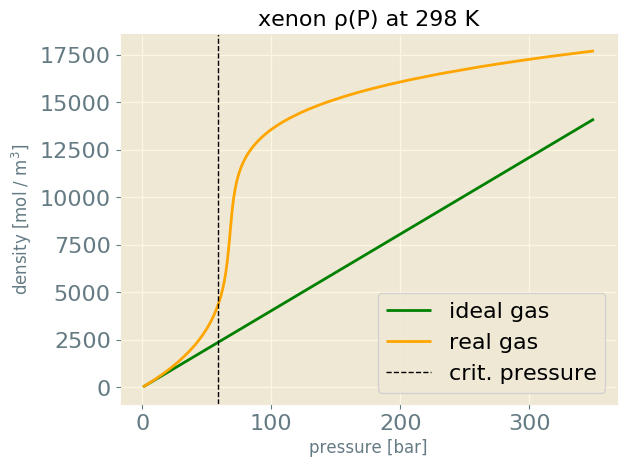

In [8]:
figure()
plot(pressures, ρ_ideal_gas, color="green", label="ideal gas")
plot(pressures, ρ_xe, 
    color="orange", label="real gas")
xlabel("pressure [bar]")
axvline(x=xe_critical_pressure, linestyle="--", color="k", label="crit. pressure", lw=1)
ylabel("density [mol / m\$^3\$]")
legend()
title("xenon ρ(P) at 298 K")
savefig("xenon_gas_density.pdf", format="pdf")

## Compressed xenon (`cXe`) storage

The premise is that we are storing some quantity `mol_desired_xe_propllant` at a specified `temperature`.

For all arrays below, element `i` represents the parameters when we choose to store at `pressures[i]` (bar); for example, `V_cXe_tank[i]` is the volume of the tank required to store the desired quantity `mol_desired_xe_propllant` (mol) of Xe at 298 K and pressure `pressures[i]` bar.

The interior volume of the tank must be equal to the volume of propellant (of course). Since we have the density of the propellant at each pressure, we thus know the volume of the tank at each choice of storage pressure.

In [9]:
volume_cxe_tank = mol_desired_xe_propellant ./ ρ_xe; # m³

Assuming the tank is spherical, we can calculate the radius of the tank for each choice of storage pressure.

In [10]:
radius_cxe_tank = (volume_cxe_tank * 3 / (4 * π)) .^ (1 / 3); # m

We apply the thin-walled tank stress model to obtain the minimum wall thickness required to contain the pressure of the compressed xenon. Thickness is found using the free-body diagram of a spherical, thin-walled tank. By taking the force of the fluid over a cross-sectional area ($P \pi  r ^ 2$) set equal to the force of the tank walls over the circumference, including the yield strength and thickness of the wall ($2 \pi  r \sigma  t$). We then isolate $t$ to solve for the thickness.

\begin{equation}
2 \pi  r \sigma  t=P \pi  r ^ 2
\end{equation}

In [11]:
thickness_cxe_tank = pressures .* radius_cxe_tank / (2 * σ_tank_material); # tank wall thickness (m)

The mass of the tank can be found using the surface area of sphere, the thickness of the sphere, and the density of the material.

In [12]:
mass_cxe_tank_material = ρ_tank_material * 4 * π * radius_cxe_tank .^ 2 .* thickness_cxe_tank; # kg

The optimum storage pressure is 77.58 bar with a tank mass of 3.60 kg.


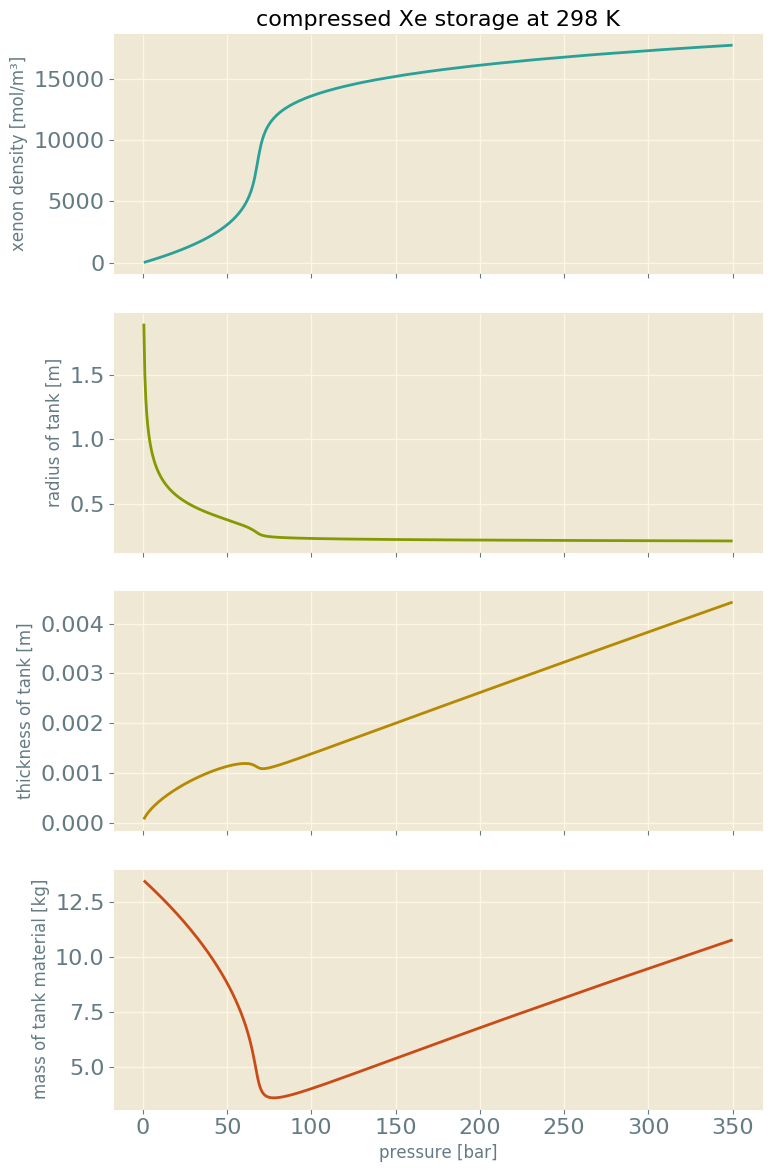

optimum: 
	storage pressure [bar] = 77.583
	mass of tank material [kg] = 3.6031983967699857
	tankage fraction [kg] = 0.04048537524460658
	storage density [mol/m³] = 11753.0


PyObject Text(0.5, 28.000000000000007, 'pressure [bar]')

In [13]:
argmin_p_mass = argmin(mass_cxe_tank_material)
@printf("The optimum storage pressure is %.2f bar with a tank mass of %.2f kg.\n", 
    pressures[argmin_p_mass],mass_cxe_tank_material[argmin_p_mass])

println("optimum: ")
println("\tstorage pressure [bar] = ", pressures[argmin_p_mass])
println("\tmass of tank material [kg] = ", mass_cxe_tank_material[argmin_p_mass])
println("\ttankage fraction [kg] = ", mass_cxe_tank_material[argmin_p_mass] / mass_desired_xe_propellant)
println("\tstorage density [mol/m³] = ", ρ_xe[argmin_p_mass])


fig, axs = subplots(4, 1, figsize=(8, 12), 
                    sharex=true, sharey=false, tight_layout=true)

axs[1].plot(pressures, ρ_xe, color="C1")
axs[1].set_ylabel("xenon density [mol/m³]")
axs[1].set_title("compressed Xe storage at 298 K")

axs[2].plot(pressures, radius_cxe_tank, color="C2")
axs[2].set_ylabel("radius of tank [m]")

axs[3].plot(pressures, thickness_cxe_tank, color="C3")
axs[3].set_ylabel("thickness of tank [m]")
# axs[3].axvline(x=xe_critical_pressure, linestyle="--", color="k", label="crit. pressure", lw=1)

axs[4].plot(pressures, mass_cxe_tank_material, color="C4")
axs[4].set_ylabel("mass of tank material [kg]")


xlabel("pressure [bar]")

$\checkmark$ compare tankage fraction to previous work [here](https://erps.spacegrant.org/uploads/images/images/iepc_articledownload_1988-2007/1991index/IEPC1991-107.pdf). optimum tankage fraction in this work is around 0.065. <br>
$\checkmark$ compare optimum storage pressure to previous work [here](https://erps.spacegrant.org/uploads/images/images/iepc_articledownload_1988-2007/1991index/IEPC1991-107.pdf). the  optimum storage density in this work is around 9900 mol/m$^3$= 1.3 g/mL.

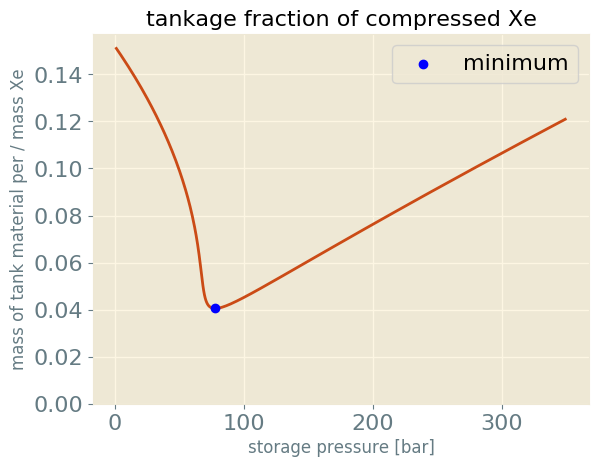

PyObject Text(0.5, 1, 'tankage fraction of compressed Xe')

In [14]:
tankage_fraction = mass_cxe_tank_material ./ mass_desired_xe_propellant

figure()
plot(pressures,tankage_fraction,color="C4")
scatter(pressures[argmin_p_mass],tankage_fraction[argmin_p_mass],label="minimum",color="b",zorder=999)

xlabel("storage pressure [bar]")
ylabel("mass of tank material per / mass Xe")
legend()
ylim(ymin=0.0)
title("tankage fraction of compressed Xe")
#savefig("Xenon van der Waals Gas in Titanium.pdf", format="pdf")

# Adsorbed xenon `aXe` storage

**TODO**: Get adsorption isotherm data at 298K for the MOFS being used and/convert check their units.

create an array of the crystals we are considering.

In [52]:
crystal_names = ["SBMOF-1", "CC3", "Ni-MOF-74", "HKUST-1", "SBMOF-2", "Co-formate",
    "FMOF-Cu", "MOF-505"] 
# removed: "ZincTetrazolate" b/c poor Langmuir fit and IRMOF-1, PCN-14 b/c we can't extrapolate confidently

8-element Array{String,1}:
 "SBMOF-1"   
 "CC3"       
 "Ni-MOF-74" 
 "HKUST-1"   
 "SBMOF-2"   
 "Co-formate"
 "FMOF-Cu"   
 "MOF-505"   

#### compute crystal densities of the materials using crystal structure data from [here](https://github.com/CorySimon/XeKrMOFAdsorptionSurvey/tree/master/xtal_structures)

In [53]:
# create a dictionary to store the crystal density values
ρ_crystal = Dict{String, Float64}()

# find crystal density using PorousMaterials.jl
for crystal_name in crystal_names
    framework = Framework(crystal_name * ".cssr")
    strip_numbers_from_atom_labels!(framework)
    ρ_crystal[crystal_name] = crystal_density(framework) # kg/m³
end

# # here I am going to manully add in the COFs we are interested in because they are a different file type
# frame1 = Framework("COF-102.cif")
# frame2 = Framework("COF-102.cif")
# strip_numbers_from_atom_labels!(frame1)
# strip_numbers_from_atom_labels!(frame2)
# ρ_crystal["COF-102"] = crystal_density(frame1)
# ρ_crystal["COF-103"] = crystal_density(frame2)

# push!(crystal_names,"COF-102")
# push!(crystal_names,"COF-103")

ρ_crystal # kg/m³

Dict{String,Float64} with 8 entries:
  "Ni-MOF-74"  => 1194.12
  "SBMOF-2"    => 1191.92
  "FMOF-Cu"    => 1619.15
  "CC3"        => 958.585
  "SBMOF-1"    => 1570.4
  "HKUST-1"    => 879.096
  "MOF-505"    => 926.618
  "Co-formate" => 1821.5

#### read in experimental adsorption isotherm data [source](https://github.com/CorySimon/XeKrMOFAdsorptionSurvey/tree/master/data )

In [54]:
path_to_isotherms = joinpath("data", "exptl_xe_isotherms")

"data/exptl_xe_isotherms"

In [55]:
xe_isotherms = Dict{String, DataFrame}()

# consider not using "ZincTetrazolate" since it can't be fit using langmuir due to the shape of the data

for crystal_name in crystal_names
    isotherm_filename = joinpath(path_to_isotherms, crystal_name, "Xe.csv")
    xe_isotherms[crystal_name] = CSV.read(isotherm_filename) 
end

xe_isotherms

Dict{String,DataFrame} with 8 entries:
  "Ni-MOF-74"  => 14×2 DataFrame…
  "SBMOF-2"    => 39×2 DataFrame…
  "FMOF-Cu"    => 24×2 DataFrame…
  "CC3"        => 27×2 DataFrame…
  "SBMOF-1"    => 16×3 DataFrame…
  "HKUST-1"    => 16×2 DataFrame…
  "MOF-505"    => 30×2 DataFrame…
  "Co-formate" => 25×2 DataFrame…

## Convert isotherms to same units

Here we convert to common units: P (bar) and Adsorption (mol/m³)

Although it is quick (and handy) to use a dictionary for the unit conversion, 
it does mean that you will have to manually enter the names and conversion factors you need.<br>
- consider checking out the Unitful.jl package [here](http://painterqubits.github.io/Unitful.jl/stable/)
- unit conversions are consistent similar work [here](https://github.com/CorySimon/XeKrMOFAdsorptionSurvey/blob/master/Xe-Kr%20adsorption%20isotherm%20survey.ipynb)

In [56]:
# Define what the desired common units are for the data
common_pressure_units = Symbol("Pressure (bar)") 
common_loading_units = Symbol("Loading (mol/m³)")

# Define a dictionary with conversion factors.
pressure_conversion = Dict{Symbol, Float64}()
loading_conversion = Dict{Symbol, Float64}()

# pressure conversions to bar
pressure_conversion[Symbol("P(bar)")] = 1.0 # (1 bar) / (1 bar)
pressure_conversion[Symbol("P(mbar)")] = 1 / 1000 # (1 bar) / (1000 mbar)
pressure_conversion[Symbol("P(kPa)")] = 1 / 100 # (1 bar) / (100 kPa)
pressure_conversion[Symbol("P(torr)")] = 1 / 750.062 # (1 bar) / (750.062 torr)
pressure_conversion[Symbol("P(atm)")] = 1 / 0.986923 # (1 bar) / (0.986923 atm)

# loading conversions to mol/kg
# these conversion factors will put the quantity into mmol/g which can then be multiplied by the crystal density 
loading_conversion[Symbol("L(mmol/g)")] = 1.0 # (1 mol/kg) / (1 mmol/g)
loading_conversion[Symbol("L(ccSTP/g)")] = 1 / 22.4 # (cc STP /g) (1000 g /kg) (1 mol/ 22.4 L STP) (1 L / 1000 cc)
loading_conversion[Symbol("L(cm3STP/g)")] =1 / 22.4
# [(% mass) / 100 g Xe / g MOF](1 mol /MW_Xe g) (1000 g /1 kg)
loading_conversion[:PercentMass] = 1000.0 / xe_atomic_mass / 100.0
# this one is an exception where xtal density not needed
loading_conversion[Symbol("L(mol/L)")] = 1000.0 # (mol / L)(1000 L / m3)

1000.0

iterate over the dataframes and apply the unit conversion so we have units:
* pressure: bar
* adsorption: mol/m$^3$

In [57]:
for mof in keys(xe_isotherms)
    # loop over columns in the adsorption isotherm DataFrame
    for col_name in names(xe_isotherms[mof])
        # convert pressure units to bar
        if col_name in keys(pressure_conversion)
            xe_isotherms[mof][!, common_pressure_units] = xe_isotherms[mof][!, col_name] * pressure_conversion[col_name]
        # convert loading units to mol/m3
        elseif col_name in keys(loading_conversion)
            if col_name == Symbol("L(mol/L)")
                xe_isotherms[mof][!,common_loading_units] = xe_isotherms[mof][!, col_name] * loading_conversion[col_name]
            else 
                xe_isotherms[mof][!,common_loading_units] = xe_isotherms[mof][!, col_name] * loading_conversion[col_name] * ρ_crystal[mof] 
            end 
        else  
            print(mof, " has units with unknow conversion: ",col_name,"\n") 
        end
    end
end

SBMOF-1 has units with unknow conversion: Weight(mg)


In [58]:
xe_isotherms["HKUST-1"]

,P(mbar),PercentMass,Pressure (bar),Loading (mol/m³)
,Float64,Float64,Float64,Float64
1,0.0,0.0,0.0,0.0
2,2.1,0.36109,0.0021,24.1774
3,5.0,0.84593,0.005,56.6407
4,10.0,1.5732,0.01,105.336
5,20.0,2.77175,0.02,185.587
6,50.0,5.31803,0.05,356.078
7,97.9,7.7253,0.0979,517.261
8,198.4,11.5447,0.1984,772.997
9,301.6,14.43,0.3016,966.19


### Fit Langmuir adsorption model to the MOF xenon adsorption data

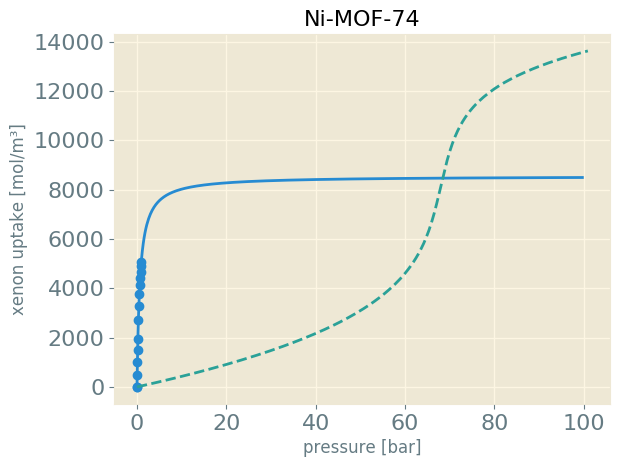

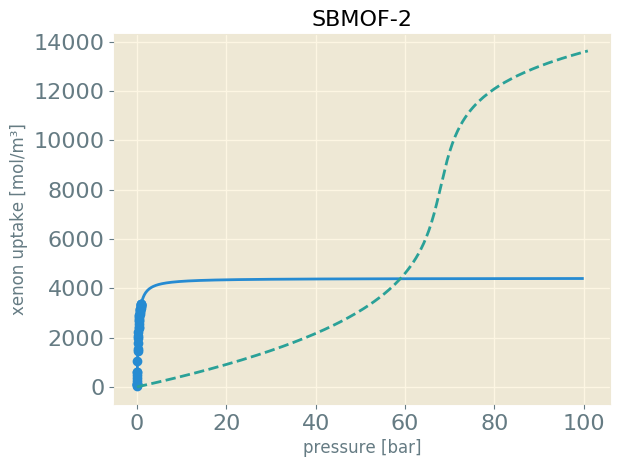

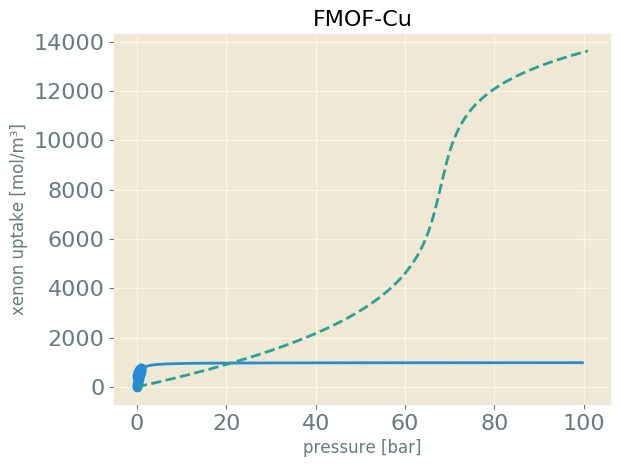

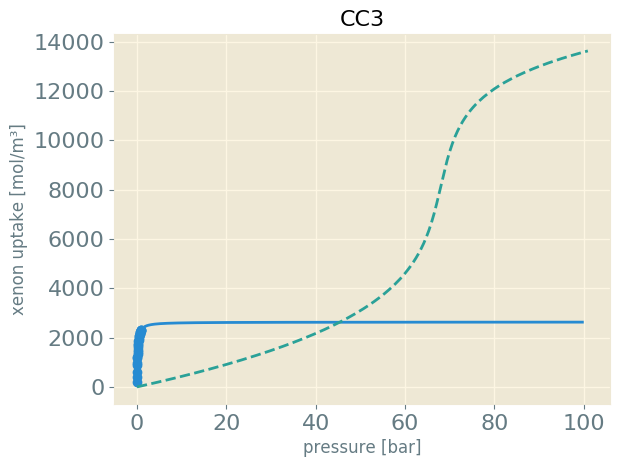

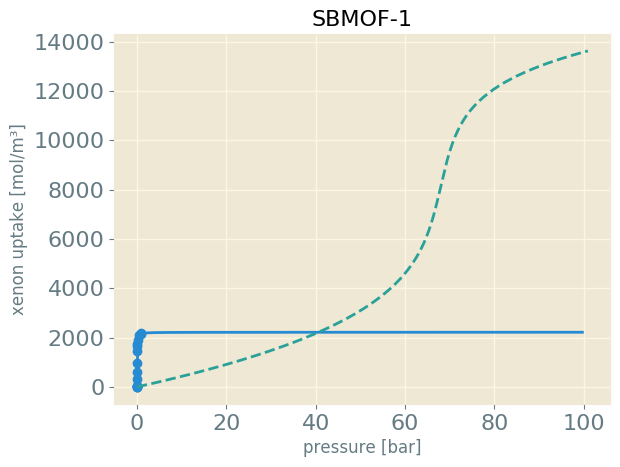

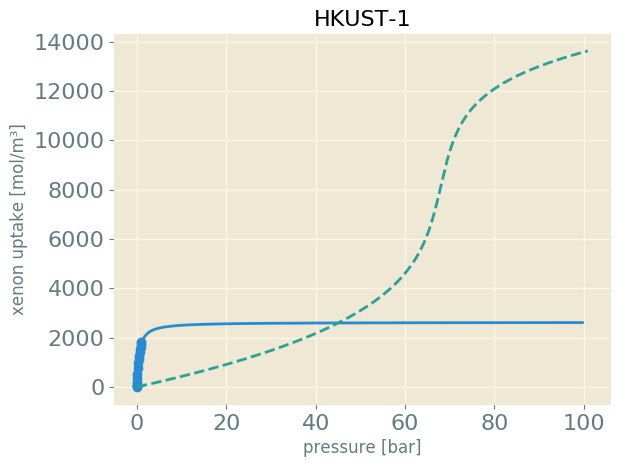

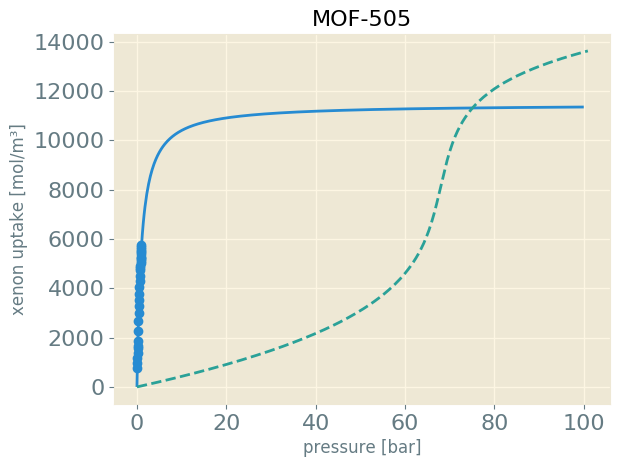

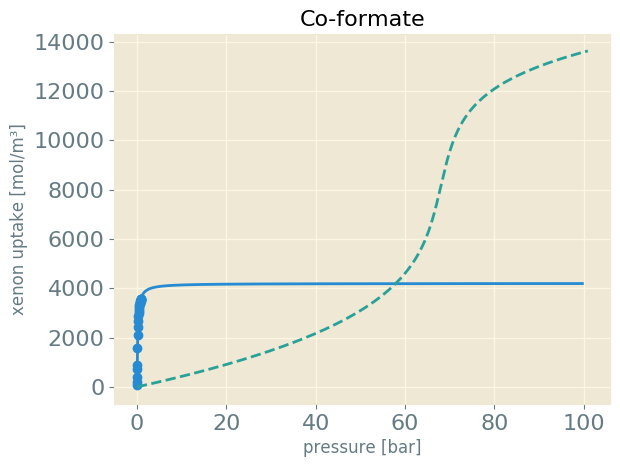

In [84]:
function plot_mof_data_and_langmuir_fit(mof::String, max_pressure::Float64)
    # fit Langmuir adsorption model
    params_langmuir = fit_adsorption_isotherm(copy(xe_isotherms[mof]), common_pressure_units, 
        common_loading_units, :langmuir)
    
    # plot fit
    figure()    
    xlabel("pressure [bar]")
    ylabel("xenon uptake [mol/m³]")
    title(mof)
    # expt'l data
    scatter(xe_isotherms[mof][:, common_pressure_units], xe_isotherms[mof][:, common_loading_units])
    # Langmuir fit
    p_plot = range(0.0, stop=max_pressure, length=500)
    ρ_langmuir = (params_langmuir["M"] .*  params_langmuir["K"] .* p_plot) ./ (1 .+ params_langmuir["K"] * p_plot)
    plot(p_plot, ρ_langmuir)
    # bulk gas density
    go_up_to_id = findfirst(pressures .> max_pressure) + 1
    plot(vcat([0], pressures[1:go_up_to_id]), vcat([0], ρ_xe[1:go_up_to_id]), linestyle="--")
end

for mof in keys(xe_isotherms)
    plot_mof_data_and_langmuir_fit(mof, 100.0)
end

## We will now analyze the properties of the tank carrying MOF

Using the function `fit_adsorption_isotherm` from Porous Materials, we calculated `M`, the density of gas in the MOF at saturation, and the Langmuir constant `K`. The Langmuir adsorption model for the loading `L` is:
\begin{equation}
L = M KP/(1+KP)
\end{equation} 

Using thin-walled theory, the thickness of the wall of the container storing the mof is equal to the pressure multiplied by the radius of the container divided by two times the tensile strength of the container material. 
\begin{equation}
t_{tank with mof} = P r_{tank with mof} / 2\sigma
\end{equation} 


In [44]:
function analyze_adsorbed_xe_tank(P::Array{Float64, 1}, df_mof::DataFrame, ρ_mof::Float64)
    
    # The Langmuir model was then fitted to the experimental data and the root mean square was calculated,
    # showing how good of a fit the model is to the experimental data.
    params_langmuir = fit_adsorption_isotherm(copy(df_mof), common_pressure_units, common_loading_units, :langmuir)
    ρ_langmuir = (params_langmuir["M"] .*  params_langmuir["K"] .* P) ./ (1 .+ params_langmuir["K"] * P) # mol/m³
    
    # The volume of the tank storing the MOF is equal to the volume of the MOF
    # required to store the desired amount of propellant.
    vol_axe_tank = mol_desired_xe_propellant ./ ρ_langmuir # m³
    
    # Find the corresponding radius of the vessel, assumed spherical.
    radius_axe_tank = (vol_axe_tank .* (3 / (4 * π))) .^ (1 / 3) # m
    
    # Mass of MOF needed to carry desired amount of gas.
    mass_mof_needed = vol_axe_tank * ρ_mof # kg
    
    # Thin-walled theory 
    t_axe_tank = P .* radius_axe_tank / (2 * σ_tank_material) # m
    
    # The total mass of the tank and MOF for the desired amount of propellant is equal to the mass of the MOF 
    # required to store the desired amount of propellant, plus the mass of the thin-walled tank storing the MOF.
    mass_axe_tank_material = 4 * π * radius_axe_tank .^ 2 .* t_axe_tank * ρ_tank_material # kg
    mass_axe_tank_total = mass_mof_needed .+ mass_axe_tank_material # kg
    
    adsorption_tankage_fraction = mass_axe_tank_total / mass_desired_xe_propellant
    minimum_index = argmin(adsorption_tankage_fraction)
    
    return Dict("Mass of tank material (kg)" => mass_axe_tank_material,
                            "Mass of MOF with adsorbed Xe (kg)" => mass_mof_needed,
                            "Total mass of Xe tank (kg)" => mass_axe_tank_total,
                            "Density of gas in MOF (mol/m³)" => ρ_langmuir,
                            "Adsorption tankage fraction" => adsorption_tankage_fraction,
                            "Minimum index" => minimum_index,
                            "Inner radius (m)" => radius_axe_tank,
                            "Thickness of tank walls (m)" => t_axe_tank,
                            "Inner volume of tank (m³)" => vol_axe_tank,
                            "Langmuir K" => params_langmuir["K"],
                            "Langmuir M" => params_langmuir["M"] )
end

analyze_adsorbed_xe_tank (generic function with 1 method)

In [45]:
dict_axe = Dict{String, Dict}()

for material in crystal_names
    dict_axe[material] = analyze_adsorbed_xe_tank(pressures, xe_isotherms[material], ρ_crystal[material]) 
end

# dict_axe

In [49]:
# dict_axe["SBMOF-1"]

In [47]:
function make_plots(mof_name::String, axe_dict::Dict)
    argmin_p_mass = axe_dict["Minimum index"]
    @printf("The optimum storage pressure is %.2f bar with a tank mass of %.2f kg.\n", 
        pressures[argmin_p_mass],axe_dict["Mass of tank material (kg)"][argmin_p_mass])

    println("optimum: ")
    println("\tstorage pressure [bar] = ", pressures[argmin_p_mass])
    println("\tmass of tank material [kg] = ", axe_dict["Mass of tank material (kg)"][argmin_p_mass])
    println("\ttankage fraction [kg] = ", axe_dict["Adsorption tankage fraction"][argmin_p_mass])
    println("\tstorage density [mol/m³] = ", axe_dict["Density of gas in MOF (mol/m³)"][argmin_p_mass])

    fig, axs = subplots(4, 1, figsize=(8, 12), 
                    sharex=true, sharey=false, tight_layout=true)
    
    axs[1].plot(pressures, axe_dict["Density of gas in MOF (mol/m³)"], color="C1")
    axs[1].scatter(xe_isotherms[mof_name][!,common_pressure_units],xe_isotherms[mof_name][!,common_loading_units],
        label="isotherm data")
    axs[1].legend()
    axs[1].set_ylabel("xenon density [mol/m³]")
    axs[1].set_title("Adsobed Xe storage at 298 K")

    axs[2].plot(pressures, axe_dict["Inner radius (m)"], color="C2")
    axs[2].set_ylabel("radius of tank [m]")

    axs[3].plot(pressures, axe_dict["Thickness of tank walls (m)"], color="C3")
    axs[3].set_ylabel("thickness of tank [m]")
    # axs[3].axvline(x=xe_critical_pressure, linestyle="--", color="k", label="crit. pressure", lw=1)

    axs[4].plot(pressures, axe_dict["Mass of tank material (kg)"], color="C4")
    axs[4].set_ylabel("mass of tank material [kg]")

    xlabel("pressure [bar]")
    ylim(ymin=0.0)

end

make_plots (generic function with 1 method)

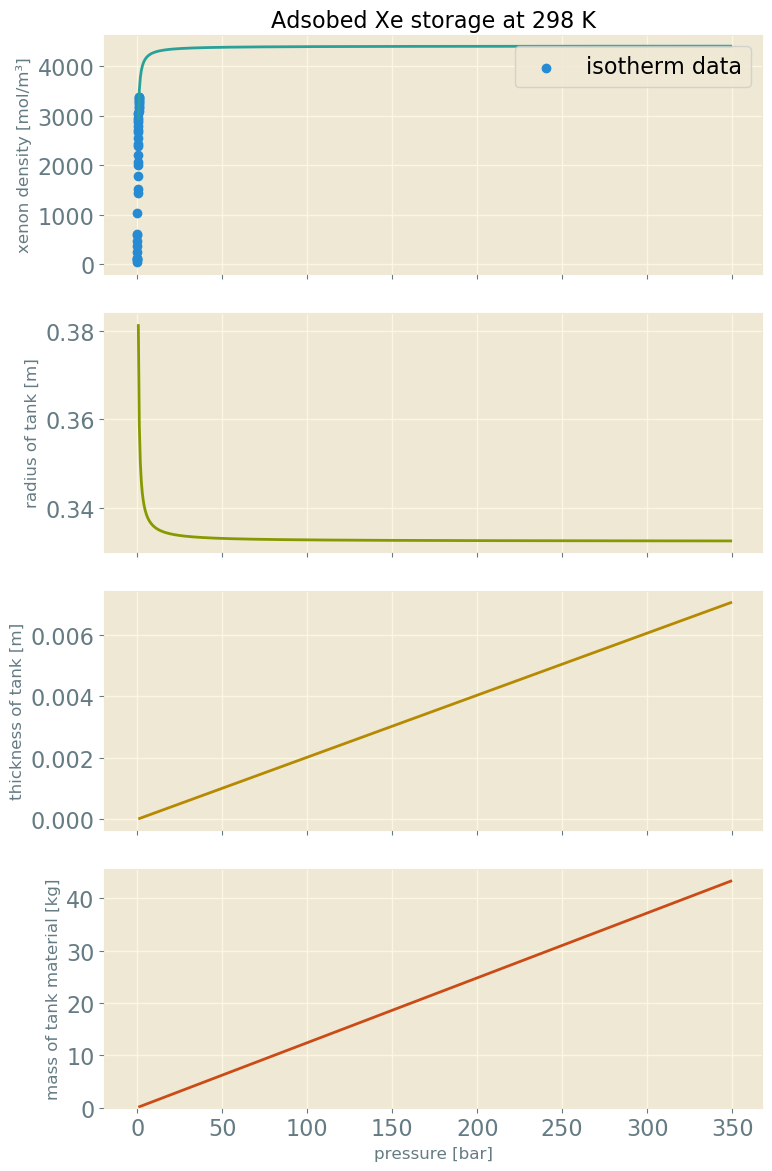

The optimum storage pressure is 21.00 bar with a tank mass of 2.64 kg.
optimum: 
	storage pressure [bar] = 21.0
	mass of tank material [kg] = 2.6373813676319067
	tankage fraction [kg] = 2.118394137110992
	storage density [mol/m³] = 4346.270016235517


(0.0, 45.53996315711014)

In [48]:
make_plots("SBMOF-2",dict_axe["SBMOF-2"])

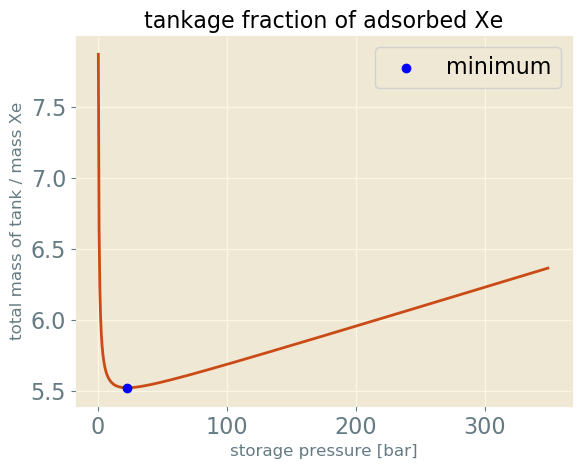

Toltal tank mass at optimum pressure = 5.522499213185226

In [27]:
min = dict_axe["SBMOF-1"]["Minimum index"]
figure()
scatter(pressures[min],dict_axe["SBMOF-1"]["Adsorption tankage fraction"][min],label="minimum",color="b",zorder=999)
plot(pressures,dict_axe["SBMOF-1"]["Adsorption tankage fraction"],color="C4")
xlabel("storage pressure [bar]")
ylabel("total mass of tank / mass Xe")
legend()
title("tankage fraction of adsorbed Xe")
# ylim(ymin=0.0)
print("Toltal tank mass at optimum pressure = ",dict_axe["SBMOF-1"]["Adsorption tankage fraction"][min])

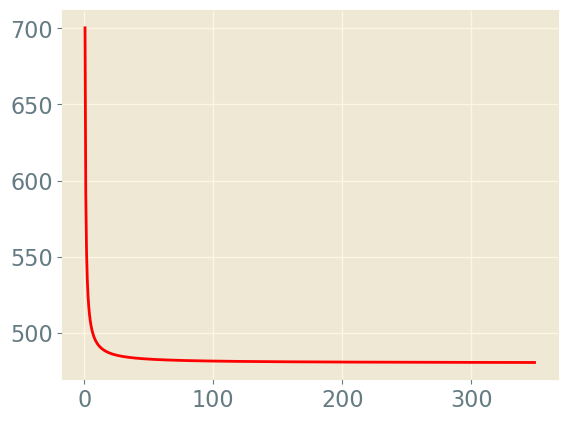

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9aa43a0b00>

In [28]:
plot(pressures,dict_axe["SBMOF-1"]["Mass of MOF with adsorbed Xe (kg)"],color="r")
# this does NOT make intuitive sense to me. Should the mass of the required MOF material go down with pressure?

In [ ]:
#################################################################################################################

## Langmuir fit for all mofs

In [29]:
for crystal in crystals
    figure()
    ax = plt.gca()
    scatter(dict_isotherms[Base.basename(crystal, ".cif")][!, Symbol("P(bar)")],
            dict_isotherms[Base.basename(crystal, ".cif")][!, :mol_m3], color="b",
            label=Base.basename(crystal, ".cif") * " experimental data")
    lim = ax.get_xlim()
    plot(P, dict_aXe[Base.basename(crystal, ".cif")]["Density of gas in MOF (mol/m³)"], color="g",
            label="Langmuir fit")
    xlabel("Pressure [bar]")
    ylabel("Adsorption [mol/m³]")
    ax.set_xlim(lim)
    title(Base.basename(crystal, ".cif"))
    legend()
    #savefig(Base.basename(crystal, ".cif") * " Langmuir fit")
end

UndefVarError: UndefVarError: crystals not defined

## adsorbed xenon storage for each MOF

In [30]:
for crystal in crystal_names
    figure()
    plot(pressures, dict_axe[crystal]["Mass of adsorbed Xe tank (kg)"] / 
        mass_desired_propellant, color="C4", lw=3, label=crystal_names[crystal] * " total")
    plot(pressures, dict_axe[crystal]["Mass of MOF with adsorbed Xe (kg)"] / 
        mass_desired_propellant, color="C4", label=crystal_names[crystal], linestyle="--")
    plot(P, dict_axe[crystal]["Mass of tank material with adsorbed Xe (kg)"] / 
        mass_desired_propellant, color="C4", label=crystal_names[crystal] * " tank material", linestyle="-.")
    xlabel("storage pressure [bar]")
    ylabel("tankage fraction [kg material / kg propellant]")
    title("adsorbed Xe storage")
    ax = gca()
    ax.set_xscale("log")
    legend()
end

KeyError: KeyError: key "Mass of adsorbed Xe tank (kg)" not found

## juxtapose compressed vs adsorbed xenon storage

In [31]:
for crystal in crystals
    figure()
    plot(real_gas[!, Symbol("Pressure (bar)")], m_cXe_tank_material / mass_desired_propellant, color="C0", label="(cXe) total = tank material")

    plot(P, dict_aXe[Base.basename(crystal, ".cif")]["Mass of adsorbed Xe tank (kg)"] / 
        mass_desired_propellant, color="C4", lw=3, label="(aXe) total")
    plot(P, dict_aXe[Base.basename(crystal, ".cif")]["Mass of tank material with adsorbed Xe (kg)"] / mass_desired_propellant,
        color="C4", label="(aXe) tank material", linestyle="--")
    plot(P, dict_aXe[Base.basename(crystal, ".cif")]["Mass of MOF with adsorbed Xe (kg)"] / mass_desired_propellant,
        color="C4", label="(aXe) MOF", linestyle="-.")

    xlabel("storage pressure [bar]")
    ylabel("tankage fraction [kg material / kg propellant]")
    ax = gca()
    ax.set_xscale("log")
    title(Base.basename(crystal, ".cif"))
    legend()
    display()
end

UndefVarError: UndefVarError: crystals not defined

## bulk gas density vs. MOF gas density

In [32]:
for crystal in crystals
    figure()
    ax = plt.gca()
    plot(real_gas[!, Symbol("Pressure (bar)")], real_gas[!, Symbol("Density (mol/m3)")], color="C0", label="bulk gas density")
    lim = ax.get_xlim()
    
    plot([0; P], [0; dict_aXe[Base.basename(crystal, ".cif")]["Density of gas in MOF (mol/m³)"]], 
        color="C4", label="MOF gas density")

    ylabel("density [mol/m³]")
    xlabel("pressure [bar]")
    ax.set_xlim(lim)
    legend()
    xlim(-0.01,1)
    ylim(-10,3000)
    display()
    title(Base.basename(crystal, ".cif"))
    
    a = plt.axes([.6, .2, .25, .25])
    a.plot([0; real_gas[!, Symbol("Pressure (bar)")]], [0; real_gas[!, Symbol("Density (mol/m3)")]], color="C0", label="bulk gas density")    
    a.plot([0; P], [0; dict_aXe[Base.basename(crystal, ".cif")]["Density of gas in MOF (mol/m³)"]], 
        color="C4", label="MOF gas density")
    a.set_xlim([-0.01, 0.1])
    a.set_ylim([-0.1, 5])
    #savefig(Base.basename(crystal, ".cif") * " gas density vs bulk gas density")
end

UndefVarError: UndefVarError: crystals not defined

## xenon propellant storage performance

MOF and tank material performance

In [33]:
markers = ["D", "v", "1", "X", "s", "P", "*"]

figure()
scatter(real_gas[!, Symbol("Pressure (bar)")][cXe_minimum_index], (m_cXe_tank_material / mass_desired_propellant)[cXe_minimum_index], 
    color="k", label="(cXe) total = tank material")

for (i, crystal) in enumerate(crystals)
    scatter(P[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            (dict_aXe[Base.basename(crystal, ".cif")]["Mass of adsorbed Xe tank (kg)"] / 
            mass_desired_propellant)[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            lw=3, label="(aXe) " * Base.basename(crystal, ".cif"), marker=markers[i%(length(markers))+1])
end
xlabel("storage pressure [bar]")
ylabel("tankage fraction [kg material / kg propellant]")
legend()
title("MOF + tank material performance")


UndefVarError: UndefVarError: real_gas not defined

Tank material performance

In [34]:
figure()
scatter(real_gas[!, Symbol("Pressure (bar)")][cXe_minimum_index], (m_cXe_tank_material / mass_desired_propellant)[cXe_minimum_index], 
    color="k", label="(cXe) total = tank material")

for (i, crystal) in enumerate(crystals)
    scatter(P[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            (dict_aXe[Base.basename(crystal, ".cif")]["Mass of tank material with adsorbed Xe (kg)"] / 
            mass_desired_propellant)[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            lw=3, label="(aXe) " * Base.basename(crystal, ".cif"), marker=markers[i%(length(markers))+1])
end
xlabel("storage pressure [bar]")
ylabel("tankage fraction [kg material / kg propellant]")
legend()
title("Tank material")

# a = plt.axes([.6, .2, .25, .25])
# a.scatter(P[cXe_minimum_index], (m_cXe_tank_material / mass_desired_propellant)[cXe_minimum_index], 
#     color="y", label="(cXe) total = tank material")

# for (i, crystal) in enumerate(crystals)
#     a.scatter(P[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
#             (dict_aXe[Base.basename(crystal, ".cif")]["Mass of tank material with adsorbed Xe (kg)"] / 
#             mass_desired_propellant)[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
#             lw=3, label="(aXe) " * Base.basename(crystal, ".cif"), marker=markers[i%(length(markers))+1])
# end
# a.set_xlim([-1, 5])
# a.set_ylim([-0.01, 0.06])

UndefVarError: UndefVarError: real_gas not defined

Performance of radii of tanks

In [35]:
figure()
scatter(real_gas[!, Symbol("Pressure (bar)")][cXe_minimum_index], r_cXe_tank[cXe_minimum_index], 
    color="k", label="(cXe)tank")

for (i, crystal) in enumerate(crystals)
    scatter(P[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            (dict_aXe[Base.basename(crystal, ".cif")]["Inner radius (m)"])[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            lw=3, label="(aXe) " * Base.basename(crystal, ".cif"), marker=markers[i%(length(markers))+1])
end
xlabel("storage pressure [bar]")
ylabel("inner radius of tanks (m)")
legend()
title("Tank radius")

UndefVarError: UndefVarError: real_gas not defined

Performance of tank thickness

In [36]:
m = t_cXe_tank[cXe_minimum_index] / real_gas[!, Symbol("Pressure (bar)")][cXe_minimum_index]

figure()
plot(real_gas[!, Symbol("Pressure (bar)")], m * real_gas[!, Symbol("Pressure (bar)")], label="theoretical thickness", 
    linewidth=1, color="w")
scatter(real_gas[!, Symbol("Pressure (bar)")][cXe_minimum_index], t_cXe_tank[cXe_minimum_index], 
    color="k", label="(cXe)tank", zorder=999)

for (i, crystal) in enumerate(crystals)
    scatter(P[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            (dict_aXe[Base.basename(crystal, ".cif")]["Thickness of tank walls (m)"])[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            lw=3, label="(aXe) " * Base.basename(crystal, ".cif"), marker=markers[i%(length(markers))+1], zorder=999)
end
xlim(0,80)
xlabel("storage pressure [bar]")
ylabel("thickness of tanks (m)")
legend()
title("Tank thickness")

UndefVarError: UndefVarError: t_cXe_tank not defined

Performance of tank volume

In [37]:
figure()
scatter(real_gas[!, Symbol("Pressure (bar)")][cXe_minimum_index], V_cXe_tank[cXe_minimum_index], 
    color="k", label="(cXe)tank")

for (i, crystal) in enumerate(crystals)
    scatter(P[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            (dict_aXe[Base.basename(crystal, ".cif")]["Inner volume of tank (m³)"])[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            lw=3, label="(aXe) " * Base.basename(crystal, ".cif"), marker=markers[i%(length(markers))+1])
end
xlabel("storage pressure [bar]")
ylabel("volume of tank (m³)")
legend()
title("Tank volume")

UndefVarError: UndefVarError: real_gas not defined

In [38]:
figure()
# scatter(real_gas[!, Symbol("Pressure (bar)")][cXe_minimum_index], V_cXe_tank[cXe_minimum_index], 
#     color="k", label="(cXe)tank")

for (i, crystal) in enumerate(crystals)
    scatter(1 / (dict_aXe[Base.basename(crystal, ".cif")]["Langmuir K"]),
            P[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], lw=3, label="(aXe) " * Base.basename(crystal, ".cif"), 
            marker=markers[i%(length(markers))+1])
end
xlabel("1/K")
ylabel("storage pressure [bar]")
legend()
title("Tank volume")

UndefVarError: UndefVarError: crystals not defined